# **Convolutional Neural Networks for Image Classification**

## **Introduction**

Convolutional Neural Networks (CNNs) have transformed image classification by effectively capturing spatial patterns in data. Inspired by the visual cortex, CNNs excel at recognizing features and generalizing them across images. This work examines their application in image classification, highlighting their structure and functionality.

The first step when dealing with a deep learning project is to ensure we have access to GPU acceleration, as it significantly speeds up training and computation, especially for large datasets and complex models. This can be verified by checking the system's hardware capabilities and configuring the deep learning framework (such as TensorFlow or PyTorch) to utilize the GPU. If a GPU is not available locally, cloud platforms like Google Colab, AWS, or Azure can provide GPU instances for efficient training.

In [3]:
!nvidia-smi

Wed Dec 18 12:40:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2070 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   56C    P8              2W /   80W |       4MiB /   8192MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
# Used to create block diagrams
from graphviz import Digraph

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torchvision.transforms.v2 as transforms
import torchvision.io as tv_io
import torch.nn as nn
import torch._dynamo
import torch

import glob
import triton
import utils
import os
import gdown
import zipfile

torch._dynamo.config.suppress_errors = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## **Downloading the Dataset**

Before starting, let's just download the Dataset that we will use to train our CNN, since it is around 250MB and it cannot be saved in the repository as it is due to size restrictions.

In [5]:
url = "https://drive.google.com/uc?export=download&id=1gf7kRHhQDWtTWKMJBeRdCBmtCzaAAxMb"
folder_name = "data"

# Name of the ZIP file to save locally
dataset_zip = f"{folder_name}.zip"
os.makedirs(folder_name, exist_ok=True)

# Download the ZIP file
gdown.download(url, dataset_zip, quiet=False)

# Extract the contents
with zipfile.ZipFile(dataset_zip, "r") as zip_ref:
    zip_ref.extractall(folder_name)

# Delete the ZIP file
os.remove(dataset_zip)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1gf7kRHhQDWtTWKMJBeRdCBmtCzaAAxMb
From (redirected): https://drive.google.com/uc?export=download&id=1gf7kRHhQDWtTWKMJBeRdCBmtCzaAAxMb&confirm=t&uuid=1c06584d-48a1-4b8e-9438-dcea353be0c7
To: /home/rorro6787/Escritorio/Universidad/4Carrera/object-clasification-dl/notebooks/data.zip
100%|██████████| 268M/268M [00:09<00:00, 28.4MB/s] 


## **The Convolutional Deep Learning Model**

We will use as starting point a pretrained model which a deep learning model that has already been trained on a large dataset (e.g., ImageNet). It captures general features like edges, shapes, and textures, which can be reused for specific tasks through transfer learning.

### Benefits of Using a Pretrained Model
- **Transfer Learning**: Leverages general features for specific tasks.
- **Reduced Training Time**: Avoids retraining basic patterns.
- **Better Performance**: Works well even with limited data.
- **Expert Design**: Uses models trained by experts on high-quality datasets.

### Why Use `vgg16` with `VGG16_Weights.DEFAULT`?
- **VGG16**: A deep and effective CNN architecture for image classification.
- **Pretrained Weights**: Trained on ImageNet, providing a strong foundation for feature extraction.
- **Advantages**: Saves time, boosts performance, and simplifies fine-tuning for your task.

In [6]:
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights

weights = VGG16_Weights.DEFAULT
vgg_model = vgg16(weights=weights)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/rorro6787/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:15<00:00, 35.1MB/s] 


In [7]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

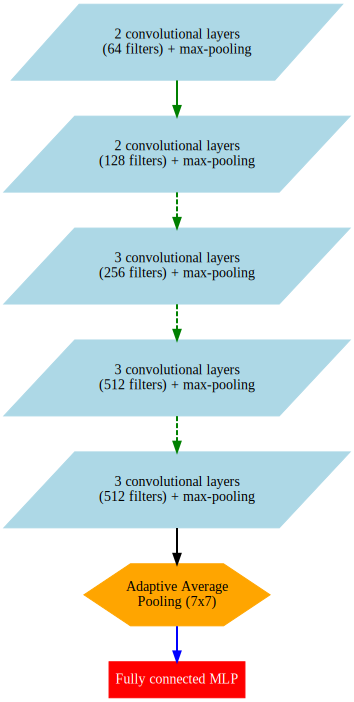

In [8]:
dot = Digraph()

# Personalización de nodos
dot.node('A', '2 convolutional layers\n(64 filters) + max-pooling', shape='parallelogram', style='filled', color='lightblue', fontcolor='black')
dot.node('B', '2 convolutional layers\n(128 filters) + max-pooling', shape='parallelogram', style='filled', color='lightblue', fontcolor='black')
dot.node('C', '3 convolutional layers\n(256 filters) + max-pooling', shape='parallelogram', style='filled', color='lightblue', fontcolor='black')
dot.node('D', '3 convolutional layers\n(512 filters) + max-pooling', shape='parallelogram', style='filled', color='lightblue', fontcolor='black')
dot.node('E', '3 convolutional layers\n(512 filters) + max-pooling', shape='parallelogram', style='filled', color='lightblue', fontcolor='black')
dot.node('F', 'Adaptive Average\nPooling (7x7)', shape='hexagon', style='filled', color='orange', fontcolor='black')
dot.node('G', 'Fully connected MLP', shape='rect', style='filled', color='red', fontcolor='white')

# Personalización de bordes
dot.edge('A', 'B', color='green', penwidth='2.0')
dot.edge('B', 'C', color='green', penwidth='2.0', style='dashed')
dot.edge('C', 'D', color='green', penwidth='2.0', style='dashed')
dot.edge('D', 'E', color='green', penwidth='2.0', style='dashed')
dot.edge('E', 'F', color='black', penwidth='2.0', style='bold')
dot.edge('F', 'G', color='blue', penwidth='2.0', style='bold')

# Renderizar
dot.render('simple_diagram', format='svg', cleanup=True)
dot

## Adapting a Pretrained Model for our Problem

While a pretrained model provides a solid starting point by leveraging learned features from a large dataset like ImageNet, it is important to adapt it for your specific problem. This is because the pretrained model is generally designed for a different task (e.g., ImageNet classification with 1,000 classes) than what you are working on (e.g., classifying images into 6 classes).

In this project, you're training a machine learning model to classify fruits as fresh or rotten. The dataset you're using, which is organized in the `data/fruits` folder, includes six categories:

- Fresh Apples
- Fresh Oranges
- Fresh Bananas
- Rotten Apples
- Rotten Oranges
- Rotten Bananas

The task at hand is a **multi-class classification** problem, where the model needs to assign an image to one of the six categories, therefore we build this new model from the pretrained one, therefore, the first step is to freeze the pretrain model's weights. This is important because the convolutional layers in the pretrained VGG16 model have already learned general features like edges, shapes, and textures. Freezing these layers prevents them from being overwritten during training, ensuring that this valuable knowledge is retained, plus it provides a much faster training process and avoidance of overfitting:

In [9]:
# Freeze base model
vgg_model.requires_grad_(False)
next(iter(vgg_model.parameters())).requires_grad

False

In [10]:
vgg_model.classifier[0:3]

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
)

In [11]:
num_classes = 6

fruit_model = nn.Sequential(
    vgg_model.features,
    vgg_model.avgpool,
    nn.Flatten(),
    vgg_model.classifier[0:3],
    nn.Linear(4096, 500),
    nn.ReLU(),
    nn.Linear(500, num_classes)
)
fruit_model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

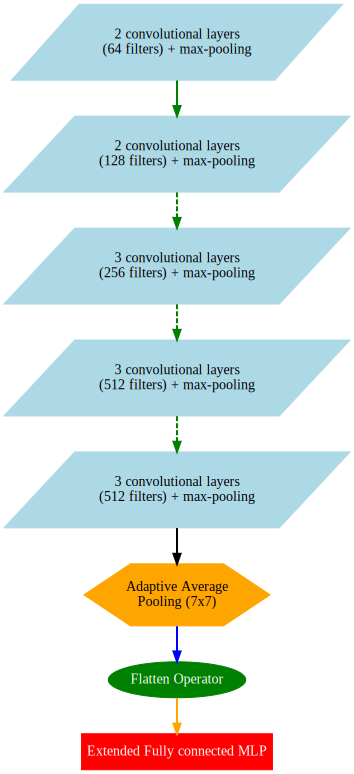

In [12]:
dot = Digraph()

# Personalización de nodos
dot.node('A', '2 convolutional layers\n(64 filters) + max-pooling', shape='parallelogram', style='filled', color='lightblue', fontcolor='black')
dot.node('B', '2 convolutional layers\n(128 filters) + max-pooling', shape='parallelogram', style='filled', color='lightblue', fontcolor='black')
dot.node('C', '3 convolutional layers\n(256 filters) + max-pooling', shape='parallelogram', style='filled', color='lightblue', fontcolor='black')
dot.node('D', '3 convolutional layers\n(512 filters) + max-pooling', shape='parallelogram', style='filled', color='lightblue', fontcolor='black')
dot.node('E', '3 convolutional layers\n(512 filters) + max-pooling', shape='parallelogram', style='filled', color='lightblue', fontcolor='black')
dot.node('F', 'Adaptive Average\nPooling (7x7)', shape='hexagon', style='filled', color='orange', fontcolor='black')
dot.node('G', 'Flatten Operator', shape='ellipse', style='filled', color='green', fontcolor='white')
dot.node('H', 'Extended Fully connected MLP', shape='rect', style='filled', color='red', fontcolor='white')

# Personalización de bordes
dot.edge('A', 'B', color='green', penwidth='2.0')
dot.edge('B', 'C', color='green', penwidth='2.0', style='dashed')
dot.edge('C', 'D', color='green', penwidth='2.0', style='dashed')
dot.edge('D', 'E', color='green', penwidth='2.0', style='dashed')
dot.edge('E', 'F', color='black', penwidth='2.0', style='bold')
dot.edge('F', 'G', color='blue', penwidth='2.0', style='bold')
dot.edge('G', 'H', color='orange', penwidth='2.0', style='bold')

# Renderizar
dot.render('simple_diagram', format='svg', cleanup=True)
dot

## **Compiling the Model**

The next step, once we have the architecture of the model prepared is to compile it. This is an optional step but very recommened because in pytorch to compile the model optimizes the model by applying various transformations to improve performance during training and inference. These optimizations can include better memory management, faster execution on hardware accelerators (like GPUs), and more efficient computation graphs.

### Understanding Entropies in Machine Learning Loss Functions

Entropy is a key concept in information theory and machine learning, representing uncertainty or unpredictability in data. Different entropy-based loss functions are used depending on the type of task: **binary classification**, **multi-class classification**, or **multi-label classification**. Below is an explanation of the common entropies and when to use them.

---

#### 1. Binary Cross-Entropy (Log Loss)
**Use Case:** Binary classification problems (e.g., "cat vs. dog").

##### Explanation
Binary cross-entropy measures the difference between the true label (0 or 1) and the predicted probability for a single output neuron. It evaluates how well the model’s predicted probability aligns with the actual class.

##### Formula
$$
\text{Loss} = - \frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right]
$$

Where:
$$
y_i: \text{Actual label (0 or 1).}
$$

$$
\hat{y}_i: \text{Predicted probability for class 1.}
$$

$$
N: \text{Total number of samples.}
$$


##### Key Points
- Requires a **single output neuron** with a **sigmoid activation function**.
- Outputs a probability value between 0 and 1.

---

#### 2. Categorical Cross-Entropy
**Use Case:** Multi-class classification problems (e.g., "dog vs. cat vs. bird").

##### Explanation
Categorical cross-entropy measures the difference between the true class (one-hot encoded) and the predicted probabilities across all classes. It evaluates how well the predicted probability distribution matches the true distribution.

##### Formula
$$
\text{Loss} = - \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{C} y_{ij} \cdot \log(\hat{y}_{ij})
$$

**Where:**

$$
y_{ij}: \text{Actual label for class } j \text{ (1 if correct, 0 otherwise).}
$$

$$
\hat{y}_{ij}: \text{Predicted probability for class } j.
$$

$$
N: \text{Total number of samples.}
$$

$$
C: \text{Total number of classes.}
$$

##### Key Points
- Requires **one output neuron per class** with a **softmax activation function**.
- The predicted outputs are normalized probabilities (sum to 1).

---

#### 3. Sparse Categorical Cross-Entropy
**Use Case:** Multi-class classification with integer-encoded labels.

##### Explanation
Sparse categorical cross-entropy is similar to categorical cross-entropy but works with integer-encoded labels instead of one-hot encoding. This makes it memory efficient when dealing with a large number of classes.

##### Key Points
- Suitable for **multi-class classification** with **large class counts**.
- Requires a **softmax activation function**.

---

#### 4. Binary Cross-Entropy for Multi-Label Classification
**Use Case:** Multi-label classification problems (e.g., predicting multiple diseases).

##### Explanation
Binary cross-entropy is extended for tasks where each example can belong to multiple classes. Each class is treated independently as a binary classification problem.

##### Key Points
- Requires **one output neuron per label** with a **sigmoid activation function**.
- Outputs independent probabilities for each label.

---

By choosing the appropriate entropy-based loss function for your task, you ensure the model learns effectively and achieves optimal results.




In [13]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(fruit_model.parameters())
fruit_model = torch.compile(fruit_model.to(device))

## **Data Augmentation**
Data augmentation is a technique used to artificially increase the size of a training dataset by applying random transformations to the original images. This helps the model generalize better and avoid overfitting, especially when you have limited data. In your case, the random transformations such as flips, rotations, and color adjustments allow the model to learn more robust features from the images of fruits.

#### Key Reasons for Using Data Augmentation:

1. **Increased Data Variability**: By applying transformations like random rotation, horizontal/vertical flips, and color changes, the model is exposed to more varied versions of the same image. This helps the model learn to identify the object (e.g., fruits) under different conditions and perspectives.

2. **Prevention of Overfitting**: When the model sees the same image multiple times, it might memorize the details rather than generalize. Data augmentation introduces randomness, which helps the model focus on learning the general features of the images rather than memorizing specific patterns.

3. **Better Generalization**: Augmentation encourages the model to become invariant to certain transformations (like rotation or color variation). This means the model will be better at recognizing fruits in real-world scenarios, where the appearance may vary (e.g., an orange could be rotated or appear brighter due to lighting).

4. **Improved Robustness**: The model becomes more robust to noise and variations in the data, which is important when deployed in real-world situations where input images can vary widely.

#### Example Transformations Applied:

- **Random Horizontal Flip**: Helps the model recognize fruits regardless of their orientation.
- **Random Rotation**: Teaches the model to recognize fruits from different angles.
- **Color Jitter**: Introduces variations in brightness, contrast, and color, helping the model adapt to different lighting conditions.
- **Random Resized Crop**: Provides different zoom levels of the fruit, improving recognition at varying distances.
- **Normalization**: Ensures the pixel values are scaled similarly to how the pretrained VGG16 model was trained, which helps the model perform better.


In [14]:
before_trans = weights.transforms()

IMG_WIDTH, IMG_HEIGHT = (224, 224)

random_trans = transforms.Compose([
    transforms.RandomHorizontalFlip(),                                                 # Randomly flip the image horizontally
    transforms.RandomRotation(20),                                                     # Randomly rotate the image by up to 20 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),     # Random changes in color
    transforms.RandomResizedCrop(IMG_WIDTH, scale=(0.8, 1.0)),                         # Crop a random portion and resize
    transforms.RandomVerticalFlip(),                                                   # Randomly flip the image vertically
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])        # Normalize using ImageNet stats
])

## **The Dataset**
In this project, I’m training a machine learning model to classify fruits as fresh or rotten. I’m using a dataset from [Kaggle](https://www.kaggle.com/sriramr/fruits-fresh-and-rotten-for-classification), which I’ve organized in the `data/fruits` folder.

The dataset includes six categories:
- Fresh Apples
- Fresh Oranges
- Fresh Bananas
- Rotten Apples
- Rotten Oranges
- Rotten Bananas

To tackle this multi-class classification problem:
1. I’ve designed the model’s output layer with **6 neurons**, each representing one category.
2. Since there are more than two classes, I’ve compiled the model using the `categorical_crossentropy` loss function to ensure it learns effectively.


In [15]:
labels = ["freshapples", "freshbanana", "freshoranges", "rottenapples", "rottenbanana", "rottenoranges"]

class MyDataset(Dataset):
    """
    A custom dataset class to handle image data for training and testing.

    Attributes:
        imgs (list): A list of preprocessed image tensors.
        labels (list): A list of corresponding labels as tensors.

    Args:
        data_dir (str): The root directory containing subdirectories for each label.

    Methods:
        __getitem__(idx): Returns the image tensor and corresponding label at the given index.
        __len__(): Returns the total number of samples in the dataset.
    """

    def __init__(self, data_dir):
        """
        Initializes the MyDataset instance by loading and preprocessing all images and labels.

        Args:
            data_dir (str): The root directory where images are stored. The directory structure
                           should have subdirectories named according to the `DATA_LABELS` list.
                           Each subdirectory contains `.png` images corresponding to that label.
        """
        self.imgs = []  # List to store image tensors
        self.labels = []  # List to store label tensors

        for l_idx, label in enumerate(labels):
            # Find all image paths in the subdirectory for the current label
            data_paths = glob.glob(data_dir + label + '/*.png', recursive=True)

            for path in data_paths:
                # Read the image in RGB mode
                img = tv_io.read_image(path, tv_io.ImageReadMode.RGB)
                # Preprocess the image and transfer it to the specified device
                self.imgs.append(before_trans(img).to(device))
                # Store the label as a tensor
                self.labels.append(torch.tensor(l_idx).to(device))

    def __getitem__(self, idx):
        """
        Retrieves a sample from the dataset at the specified index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the image tensor and its corresponding label tensor.
        """
        img = self.imgs[idx]
        label = self.labels[idx]
        return img, label

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
            int: The total number of samples.
        """
        return len(self.imgs)

In [16]:
n = 32 # Example batch size, adjust based on memory and dataset size

train_path = "data/fruits/train/"
train_data = MyDataset(train_path)

# Shuffle for training
train_loader = DataLoader(train_data, batch_size=n, shuffle=True)
train_N = len(train_loader.dataset)

valid_path = "data/fruits/valid/"
valid_data = MyDataset(valid_path)

# No shuffle for validation
valid_loader = DataLoader(valid_data, batch_size=n, shuffle=False)
valid_N = len(valid_loader.dataset)

## **Model Training**
Now that we've prepared the model and dataset, it's time to start training. The following loop runs for a specified number of epochs (in this case, 10) and iterates through the entire training dataset to adjust the model's weights.

### Epochs and Iterations

- **Epoch**: One full pass through the entire training dataset. Each epoch allows the model to adjust its weights and improve its performance.
- **Train Step**: In the `train` function, the model will be trained on the training data (`train_loader`), and after each epoch, the `validate` function will check the model's performance on a separate validation set (`valid_loader`).

By training for multiple epochs, the model will progressively improve and learn better features for classifying fruits, while data augmentation helps it to remain flexible and robust in real-world scenarios.



In [17]:
epochs = 12

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    utils.train(fruit_model, train_loader, train_N, random_trans, optimizer, loss_function)
    utils.validate(fruit_model, valid_loader, valid_N, loss_function)

Epoch: 0
Train - Loss: 33.3106 Accuracy: 0.6514
Valid - Loss: 5.7011 Accuracy: 0.8237
Epoch: 1
Train - Loss: 18.7803 Accuracy: 0.8173
Valid - Loss: 3.9619 Accuracy: 0.8967
Epoch: 2
Train - Loss: 16.0513 Accuracy: 0.8460
Valid - Loss: 3.7411 Accuracy: 0.8875
Epoch: 3
Train - Loss: 14.6670 Accuracy: 0.8511
Valid - Loss: 3.6303 Accuracy: 0.9058
Epoch: 4
Train - Loss: 13.4428 Accuracy: 0.8621
Valid - Loss: 3.9602 Accuracy: 0.9027
Epoch: 5
Train - Loss: 14.3001 Accuracy: 0.8426
Valid - Loss: 2.8614 Accuracy: 0.9027
Epoch: 6
Train - Loss: 15.2551 Accuracy: 0.8435
Valid - Loss: 5.1968 Accuracy: 0.8784
Epoch: 7
Train - Loss: 13.7250 Accuracy: 0.8562
Valid - Loss: 3.2237 Accuracy: 0.9301
Epoch: 8
Train - Loss: 15.7191 Accuracy: 0.8401
Valid - Loss: 3.5487 Accuracy: 0.9119
Epoch: 9
Train - Loss: 11.4187 Accuracy: 0.8892
Valid - Loss: 3.9866 Accuracy: 0.9058
Epoch: 10
Train - Loss: 12.5368 Accuracy: 0.8824
Valid - Loss: 4.3493 Accuracy: 0.8845
Epoch: 11
Train - Loss: 12.0494 Accuracy: 0.8824
Vali

## **Model Fine-Tunning (optinal)**

After the training process, we can already see a validation accuracy of over 85%, which is very good considering how computationally lightweight the process was. However, there is still one final step to further increase the accuracy. By unfreezing the pretrained model's weights and performing one last small training step with a very low learning rate, we can significantly boost its performance.

In [18]:
# Unfreeze the base model
vgg_model.requires_grad_(True)
optimizer = Adam(fruit_model.parameters(), lr=.0001)

In [19]:
epochs = 4

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    utils.train(fruit_model, train_loader, train_N, random_trans, optimizer, loss_function)
    utils.validate(fruit_model, valid_loader, valid_N, loss_function)

Epoch: 0
Train - Loss: 9.7946 Accuracy: 0.9027
Valid - Loss: 3.0272 Accuracy: 0.9271
Epoch: 1
Train - Loss: 9.8330 Accuracy: 0.9036
Valid - Loss: 3.3231 Accuracy: 0.9362
Epoch: 2
Train - Loss: 9.6700 Accuracy: 0.9129
Valid - Loss: 3.0254 Accuracy: 0.9301
Epoch: 3
Train - Loss: 8.8652 Accuracy: 0.9120
Valid - Loss: 2.9262 Accuracy: 0.9331


## **Model Evaluation**

After training the model, the next step is **evaluation**. If you are satisfied with the model's performance based on the validation results, you can proceed to testing and finalizing your model. However, if the performance is not as expected, it may be necessary to adjust some **hyperparameters** before continuing.

In [20]:
utils.validate(fruit_model, valid_loader, valid_N, loss_function)

Valid - Loss: 2.9262 Accuracy: 0.9331


## **Try out the Model**

After training and evaluating the model, we can test its performance on different fruit images to assess how well it generalizes to new, unseen data. By feeding the model various fruit images, we can see how accurately it can classify them based on the learned patterns and features. This step allows us to understand its real-world effectiveness and identify any potential improvements.


In [25]:
freshbanana = "images/banana.jpg"
freshapple = "images/apple.jpg"
freshorange = "images/orange.png"
rottenapple = "images/rottenapple.jpg"
rottenbanana = "images/rottenbanana.png"
rottenorange = "images/rottenorange.jpg"

images = [freshbanana, freshapple, freshorange, rottenbanana, rottenapple, rottenorange]

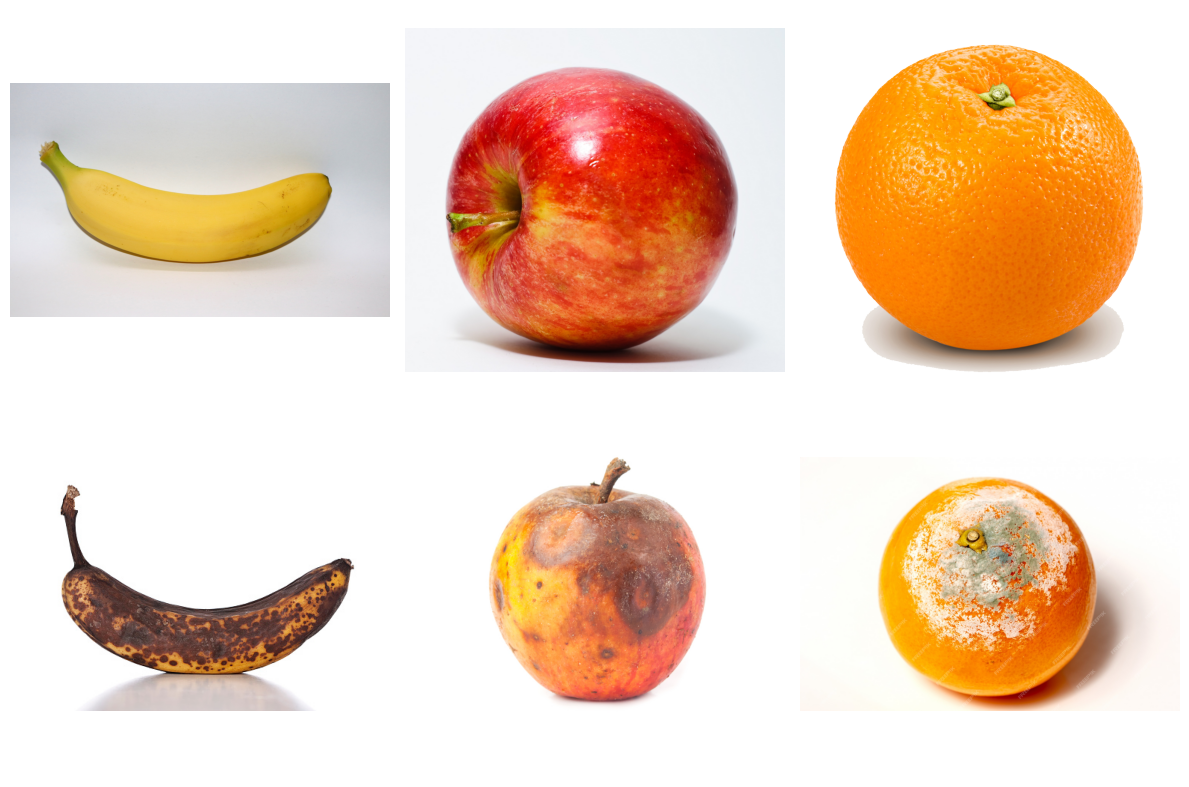

In [26]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes_flat = axes.flatten()

for i, ax in enumerate(axes_flat):
    img = PILImage.open(images[i])
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [27]:
def inference(model, image):
  model.eval()
  img = tv_io.read_image(image, tv_io.ImageReadMode.RGB)
  img_t = before_trans(img).to(device)
  output = model(img_t.unsqueeze(0))
  predicted_class = torch.argmax(output).item()
  return predicted_class

for image in images:
  predicted_class = inference(fruit_model, image)

  print(f"Image path: {image}")
  print(f"Predicted class label: {labels[predicted_class]}\n")

Image path: images/banana.jpg
Predicted class label: freshbanana

Image path: images/apple.jpg
Predicted class label: freshapples

Image path: images/orange.png
Predicted class label: freshoranges

Image path: images/rottenbanana.png
Predicted class label: rottenbanana

Image path: images/rottenapple.jpg
Predicted class label: rottenapples

Image path: images/rottenorange.jpg
Predicted class label: rottenoranges

